In [1]:
import time
#import urllib2# python2
import urllib#python3

import datetime
#from itertools import ifilter python2
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import h5py
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import bibtexparser

pd.set_option('mode.chained_assignment','warn')

In [2]:
import arxivchecker #new daily
import arxiv#query num 
import os
import time

In [3]:
import arxiv
import arxivchecker
import smtplib
from email.mime.text import MIMEText
from email.utils import formataddr
from email.header import Header
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
import os
from datetime import datetime

# scrapy paper

In [58]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:astro-ph",yearstart=2019):
    df = pd.DataFrame(columns=("title","abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = (base_url +
           "from=%i-01-01&until=%i-04-31&"%(yearstart,yearstart) +
           "metadataPrefix=arXiv&set=%s"%arxiv)
###04-31    
    while True:
        print("fetching", url)
        try:
            response = urllib.request.urlopen(url)
            
        except urllib.error.HTTPError as e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            #author=info.find(ARXIV+"author").text
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]                
            contents = {'title': info.find(ARXIV+"title").text,
                        #'author':info.find(ARXIV+"author").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }
            df = df.append(contents, ignore_index=True)
        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break
        else:
            url = base_url + "resumptionToken=%s"%(token.text)            
    return df
    

http://export.arxiv.org/oai2?verb=ListSets

In [ ]:
df = harvest(arxiv="physics:astro-ph",yearstart=2020)

In [ ]:
df.head()

In [ ]:
df.to_csv('arxiv_astro-ph_2020.csv')

In [ ]:
pwd

In [ ]:
store = pd.HDFStore("/Users/thead/git/arxiv-experiments/hep-ex.h5")
#store['df'] = df
#df = store['df']
store.close()

arxivcheckerastroph2020=arxivchecker.scrape_arxiv('astro-ph',year=2020,number=1000)
len(arxivcheckerastroph2020)
papers=arxivchecker.check_keywords_from_papers(astroph201912,['AGN','XRB','IMBH','ULX','transient'])

In [14]:
?arxivchecker.scrape_arxiv

In [4]:
?arxivchecker.check_keywords

In [5]:
papers_keywords = arxivchecker.check_keywords('astro-ph', ['AGN','XRB','IMBH','ULX','transient','radio'],mute=True)

In [6]:
len(papers_keywords)

22

In [ ]:
#papers_scrape = arxivchecker.scrape_arxiv('astro-ph',year=2020,month=4) # April 2020

In [ ]:
sortBy can be "relevance", "lastUpdatedDate", "submittedDate"
sortOrder can be either "ascending" or "descending"

In [11]:
?arxiv.query

In [14]:
paper_query=arxiv.query(query="cat:astro-ph AND abs:radio",
            max_results=100,
            start = 0,
            sort_by="lastUpdatedDate",
            sort_order="descending",
            prune=False,
            iterative=False,
            max_chunk_results=1000)

In [15]:
len(paper_query)

100

In [ ]:
for paper in paper_query:
    print(paper['title'],paper['updated'])
    #print(paper['abstract'])

## def bar_plot

In [167]:
def bar_chart(items,title,filename):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(ind, list(zip(*items))[1], width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(list(zip(*items))[0])
    fig.autofmt_xdate()
    plt.title(title)
    plt.savefig(filename)
    plt.show()

# analysis and vocabulary

## analysis astro2020 AND White Paper

In [24]:
from datetime import datetime
import os
import arxiv#query num 
now = datetime.now() # 获取当前datetime
print(now)
papersastro2020=arxiv.query(query="all:astro2020",max_results=1000)
astro2020filename='astro2020whitepaperuptodate%d-%d-%d.txt'%(now.year,now.month,now.day)
title='astro2020whitepaperuptodatetitle%d-%d-%d.txt'%(now.year,now.month,now.day)
summary='astro2020whitepaperuptodatesummary%d-%d-%d.txt'%(now.year,now.month,now.day)

if os.path.isfile(astro2020filename):
    os.remove(astro2020filename)
if os.path.isfile(title):
    os.remove(title)
if os.path.isfile(summary):
    os.remove(summary)    
    
for i in papersastro2020:
    with open(astro2020filename,'a') as f:
        f.write(i['id']+'\n'+i['title']+'\n'+i['summary']+'\n'+'\n')
    with open(title,'a') as f:
        f.write(i['title']+'\n')        
    with open(summary,'a') as f:
        f.write(i['summary']+'\n')                       

2020-04-23 16:57:19.512154


In [25]:
len(papersastro2020)

434

## title-analysis

### Counter

In [55]:
import jieba
from collections import Counter

with open(title) as f:
    s = f.read()    
    
word_list = list(jieba.cut(s.lower()))

print('分词总数:', len(word_list))
#print('示例:', word_list[:20])
words_count = Counter(word_list)
most_words = words_count.most_common(100)
#print(most_words)

from nltk.corpus import stopwords
from nltk.corpus import wordnet

stops = [word for word in stopwords.words('english')]
stops += ["=", "->"," ","\n","-",":",",","a",'x','(',')',"'","\"",'?','+',"$"]
stops +=['\\','.','/',';','~','','_']
stops +=['white','paper','astro2020']
#[!"#$&()*+,-./:;<=>?@[\\]^_{|}·~‘’]
         
words = filter(lambda w: w not in stops,
               word_list)
top_twenty_title = Counter(words).most_common(n=20)
for i in top_twenty_title:
    if wordnet.synsets(i[0]) and i[0].isalpha():
        print(i)

分词总数: 10468
('science', 94)
('high', 38)
('astronomy', 38)
('cosmic', 38)
('astrophysics', 36)
('black', 34)
('ray', 31)
('galaxy', 30)
('stars', 27)
('gravitational', 26)
('next', 25)
('evolution', 22)
('wave', 22)
('physics', 22)
('holes', 22)
('resolution', 21)
('formation', 21)
('energy', 20)
('galaxies', 19)
('imaging', 19)


### bar_plot

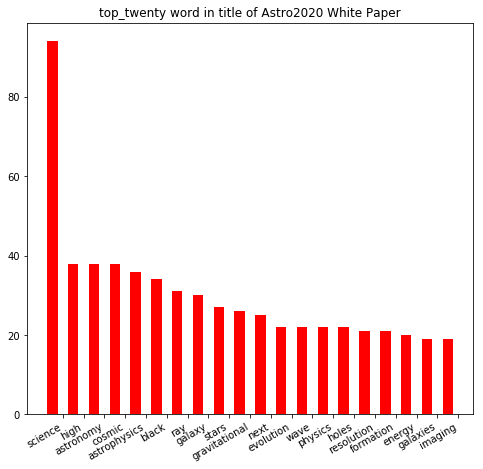

In [168]:
bar_chart(top_twenty_title,title='top_twenty word in title of Astro2020 White Paper',filename='top_20_title.png')

## summary-analysis

In [61]:
with open(summary) as f:
    s = f.read()    
word_list = list(jieba.cut(s.lower()))
#print('分词总数:', len(word_list))
#print('示例:', word_list[:20])
#words_count = Counter(word_list)
#most_words = words_count.most_common(100)
#print(most_words)

words = filter(lambda w: w not in stops,
               word_list)
top_twenty_summary = Counter(words).most_common(n=20)
for i in top_twenty_summary:
    if wordnet.synsets(i[0]) and i[0].isalpha():
        print(i)

('high', 282)
('galaxies', 250)
('large', 238)
('observations', 233)
('formation', 224)
('stars', 223)
('science', 217)
('galaxy', 212)
('new', 204)
('mass', 189)
('ray', 184)
('resolution', 178)
('decade', 177)
('star', 175)
('evolution', 174)
('stellar', 172)
('next', 170)
('understanding', 167)
('black', 162)
('universe', 162)


In [29]:
ls *.txt

astro2020whitepaperuptodate2020-4-23.txt
astro2020whitepaperuptodatesummary2020-4-23.txt
astro2020whitepaperuptodatetitle2020-4-23.txt
pos_list.txt
ra_dec.txt
ra_dec_tab.txt
ra_dec_tab_byhand.txt
searchresult.txt


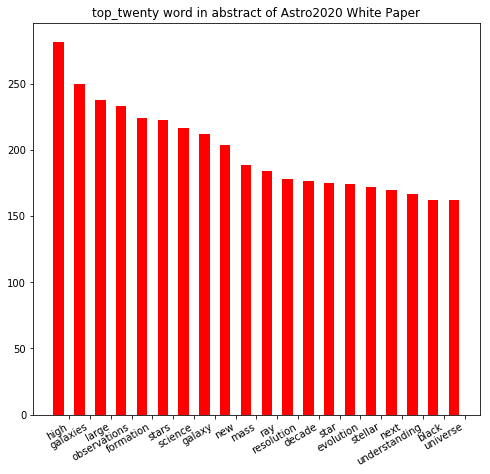

In [170]:
bar_chart(top_twenty_summary,title='top_twenty word in abstract of Astro2020 White Paper',filename='top_20_abs.png')

## all words in summary

In [75]:
with open(summary) as f:
    s = f.read()    
word_list = list(jieba.cut(s.lower()))
#print('分词总数:', len(word_list))
#print('示例:', word_list[:20])
#words_count = Counter(word_list)
#most_words = words_count.most_common(100)
#print(most_words)

words = filter(lambda w: w not in stops,
               word_list)
top_all_summary = Counter(words).most_common(n=10000)
#print(top_1000_summary)


In [205]:
# 生成 ECharts 配置数据，拼接出 HTML
# 也可直接通过 ECharts 官网生成图表

words_list = []
count_list =[]
for word in top_all_summary[:32]:
    words_list.append(word[0])
    count_list.append(word[1])

from IPython.display import HTML

# 指定图表的配置项和数据
option = """
var option = {
    title: {
        text: 'Astro2020-abstract-keywords',
    },
    tooltip: {
        trigger: 'axis',
        axisPointer: {
            type: 'shadow'
        }
    },
    legend: {
        data: ['词频']
    },
    grid: {
        left: '3%',
        right: '4%',
        bottom: '3%',
        containLabel: true
    },
    xAxis: {
        type: 'value',
        boundaryGap: [0, 0.01]
    },
    yAxis: {
        type: 'category',
        data: """ + str(words_list[::-1]) + """
    },
    series: [
        {
            name: '词频',
            type: 'bar',
            data: """ + str(count_list[::-1]) + """
        }
    ]
};
"""

head = """
<div id="showhere" style="width:800px; height:600px;"></div> 
<script> 
require.config({ paths:{ echarts: '//cdn.bootcss.com/echarts/3.2.3/echarts.min', } });
require(['echarts'],function(ec){
var myChart = ec.init(document.getElementById('showhere'));
"""

tail = """
myChart.setOption(option);
    });
</script>
"""

HTML(head + option + tail)

In [81]:
with open('astro2020-voc-least-2.txt','a') as f:
    for i,j in top_all_summary:
        if wordnet.synsets(i) and i.isalpha() and j>1:
            f.write(i+'\t'+str(j)+'\n')

In [80]:
with open('astro2020-voc-least-1.txt','a') as f:
    for i,j in top_all_summary:
        if wordnet.synsets(i) and i.isalpha() and j>0:
            f.write(i+'\t'+str(j)+'\n')

In [64]:
with open(summary) as f:
    s = f.read()    
word_list = list(jieba.cut(s.lower()))
#print('分词总数:', len(word_list))
#print('示例:', word_list[:20])
#words_count = Counter(word_list)
#most_words = words_count.most_common(100)
#print(most_words)

words = filter(lambda w: w not in stops,
               word_list)
top_1000_summary = Counter(words).most_common(n=100)
for i in top_1000_summary:
    if wordnet.synsets(i[0]) and i[0].isalpha():
        print(i)

('high', 282)
('galaxies', 250)
('large', 238)
('observations', 233)
('formation', 224)
('stars', 223)
('science', 217)
('galaxy', 212)
('new', 204)
('mass', 189)
('ray', 184)
('resolution', 178)
('decade', 177)
('star', 175)
('evolution', 174)
('stellar', 172)
('next', 170)
('understanding', 167)
('black', 162)
('universe', 162)
('cosmic', 160)
('astronomy', 156)
('space', 151)
('survey', 149)
('field', 149)
('data', 142)
('gas', 140)
('provide', 136)
('energy', 135)
('time', 132)
('also', 128)
('telescope', 124)
('planets', 121)
('telescopes', 120)
('astrophysics', 119)
('based', 118)
('physics', 112)
('surveys', 112)
('imaging', 109)
('gravitational', 106)
('first', 105)
('dark', 103)
('scientific', 102)
('z', 101)
('infrared', 101)
('properties', 100)
('range', 99)
('holes', 97)
('measurements', 97)
('wide', 96)
('scale', 95)
('spectroscopy', 95)
('accretion', 94)
('study', 92)
('current', 92)
('mission', 90)
('us', 89)
('matter', 88)
('key', 88)
('ground', 87)
('low', 87)
('galact

# daily-mail

In [82]:
pwd

'/Users/brettlv/blog/brettlv.github.io/pythoncode'

## arxiv.query

paper_query=arxiv.query(query="cat:astro-ph AND abs:radio OR abs:AGN OR abs:XRB",
            max_results=10,
            start = 0,
            sort_by="lastUpdatedDate",
            sort_order="descending",
            prune=False,
            iterative=False,
            max_chunk_results=1000)

## arxivchecker.check_keywords

In [95]:
?arxivchecker.check_keywords

In [128]:
now = datetime.now() # 获取当前datetime
if os.path.isfile('/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%s-%s-%s.txt'%(now.year,now.month,now.day)):
    os.remove('/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%s-%s-%s.txt'%(now.year,now.month,now.day))
daily_filepath='/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%s-%s-%s.txt'%(now.year,now.month,now.day)
papers_keywords = arxivchecker.check_keywords('astro-ph', ['radio','AGN','XRB','IMBH','ULX','transient','FRB','MWA','SKA'],mute=True)


for i in papers_keywords:
    print(i,papers_keywords[i])

## arxivchecker.scrape_arxiv

In [104]:
?arxivchecker.scrape_arxiv

In [ ]:
papers_scrape_arxiv=arxivchecker.scrape_arxiv()

In [85]:
print(len(papers_keywords))
print()

22



In [129]:
papers_keywords_ids=[]
for i in papers_keywords:
    print(i)
    papers_keywords_ids.append(i)

2004.10406
2004.10230
2004.10372
2004.10552
2004.10665
2004.10591
2004.10452
2004.10735
2004.10579
2004.10500
2004.10542
2004.10504
2004.10244
2004.10213
2004.10210
2004.10429
2004.10294
2004.10540
2004.10702
2004.10611
2004.10209
2004.01669


In [130]:
len(papers_keywords_ids)

22

## arxiv.query

In [91]:
?arxiv.query

In [131]:
if len(papers_keywords_ids)>0:
    print('paper today: ',len(daily_query))
    daily_query=arxiv.query(id_list=papers_keywords_ids)
#!/usr/bin/python
# -*- coding: UTF-8 -*-

paper today:  22


In [137]:
keywords_search="'radio','AGN','XRB','IMBH','ULX','transient','FRB','MWA','SKA'"
with open('/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%d-%d-%d.html'%(now.year,now.month,now.day),'w+') as f:
    for paper_id in daily_query:  
        f.write(str(now)+'\t')
        f.write('paper found:'+str(len(papers_keywords_ids)))
        f.write('<p>'+'keywords:%s'%keywords_search+'</p>') 
        f.write('<p>'+'<a href="%s"'%paper_id['id']+'>'+paper_id['id']+'</a>'+'</p>')  
        f.write('<p>'+'<a href="%s"'%paper_id['pdf_url']+'>'+'pdf_url_arxiv'+'</a>'+'</p>')
        #<p><a href="https://brettlv.github.io/">这是一个链接</a></p>     
        f.write('<p>'+paper_id['title']+'</p>') 
        f.write('<p>'+paper_id['author']+'</p>') 
        f.write('<p>'+str(paper_id['authors'])+'</p>') 
        if paper_id['arxiv_comment']:
            f.write('<p>'+paper_id['arxiv_comment']+'</p>') 
        f.write('<p> updated: '+paper_id['updated']+'</p>'+'\n')    
        f.write('<p>'+paper_id['summary']+'</p>'+'\n'+'---***---\n')
        #print(paper_id['id'],'loaded \n')   
print('all loaded')        

all loaded


In [ ]:
pwd

In [108]:
print(now)

2020-04-23 17:36:10.761122


In [134]:
#mkkneeuoshthbcjc 
#my_sender='610721578@qq.com'    # 发件人邮箱账号
#my_pass = 'tlejawmwdjzvbdcg'              # 发件人邮箱密码 授权
my_user='brettlv@icloud.com'      # 收件人邮箱账号，我这边发送给自己
#now = datetime.now() # 获取当前datetime
def mail():
    try:
        message = MIMEMultipart() 
        mail_msg = """ 
        <p>邮件内容,python email arxiv</p>
        <p>
        <a href="https://brettlv.github.io/">brettlv-github</a>      
        </p>"""
        
        #邮件正文内容
        text=MIMEText(mail_msg,'html','utf-8') 
        message.attach(text)
        
        # 构造附件1，传送当前目录下的 test.txt 文件
        att1 = MIMEText(open('/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%d-%d-%d.html'%(now.year,now.month,now.day), 'rb').read(), 'base64', 'utf-8')
        att1["Content-Type"] = 'application/octet-stream'
        dailyfilename="arxiv-daily%s-%s-%s.html"%(now.year,now.month,now.day)
        # 这里的filename可以任意写，写什么名字，邮件中显示什么名字
        att1["Content-Disposition"] = 'attachment; filename=%s'%dailyfilename
        message.attach(att1)
        
        # 构造附件2，传送当前目录下的 runoob.txt 文件
         
        message['From']=formataddr(["From brettlv",my_sender])  # 括号里的对应发件人邮箱昵称、发件人邮箱账号
        message['To']=formataddr(["FK",my_user])              # 括号里的对应收件人邮箱昵称、收件人邮箱账号
        message['Subject']="arxiv-analysis-%d-%d-%d"%(now.year,now.month,now.day)# 邮件的主题，也可以说是标题
        server=smtplib.SMTP_SSL("smtp.qq.com", 465)  # 发件人邮箱中的SMTP服务器，端口是25/465?
        #server.set_debugleverl(1)
        #server.ehlo("smtp.qq.com") 
        #server=smtplib.SMTP()
        #server.connect("smtp.qq.com",25)
        server.login(my_sender, my_pass)  # 括号中对应的是发件人邮箱账号、邮箱密码
        server.sendmail(my_sender,my_user,message.as_string())  # 括号中对应的是发件人邮箱账号、收件人邮箱账号、发送邮件
        server.quit()  # 关闭连接
        print("邮件发送成功")
    except smtplib.SMTPException as e:
        print("Error: 无法发送邮件",e)

if os.path.isfile('/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%d-%d-%d.html'%(now.year,now.month,now.day)):
    mail()
else:
    print('no paper found')

邮件发送成功


# automail-daily

In [ ]:
import time
#import urllib2# python2
import urllib#python3
import datetime
#from itertools import ifilter python2
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import h5py
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import bibtexparser
pd.set_option('mode.chained_assignment','warn')

In [203]:
#!/usr/bin/python
# -*- coding: UTF-8 -*- 

import arxiv
import arxivchecker
import smtplib
from email.mime.text import MIMEText
from email.utils import formataddr
from email.header import Header
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
import os
from datetime import datetime



def daily_run_arxiv_search_keywords():    
    papers_keywords = arxivchecker.check_keywords('astro-ph', ['radio','AGN','XRB','IMBH','ULX','transient','FRB','MWA','SKA','black hole'],mute=True)
    papers_keywords_ids=[]
    for i in papers_keywords:
        #print(i)
        papers_keywords_ids.append(i)
    return papers_keywords_ids

def daily_run_arxiv_search_ids(papers_keywords_ids):    
    if len(papers_keywords_ids)>0:
        print('paper today: ',len(papers_keywords_ids))
        daily_query=arxiv.query(id_list=papers_keywords_ids)
        return daily_query


<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<!--防止手机页面缩放-->
<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, minimum-scale=1.0, user-scalable=no">

<title>Document</title>
</head>
<body>
<!-- 文字单位设置为rem即可，通过微信开发者工具切换手机型号查看效果。 -->
<div style='border:1px red solid;border-radius:100px;font-size:1rem;'>测试手机端文字的自适应</div>
</body>


In [204]:
def daily_write_arxiv_search_ids(daily_query): 
    keywords_search="'radio','AGN','XRB','\nIMBH','ULX','transient','\nFRB','MWA','SKA','BH'"
    with open(daily_filepath,'w+') as f:
        f.write('<!DOCTYPE html><html lang="en"><head>')
        f.write('<meta charset="UTF-8">')        
        f.write('<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, minimum-scale=1.0, user-scalable=no">')      
        f.write('<title>arxiv-daily-%s-%s-%s</title>'%(now.year,now.month,now.day)) 
        f.write('</head>')  
        f.write('<body> \n <div style='+"\'"+'font-size:1rem;'+"\'"+'>')
        
        
        f.write(str(now)+'\t'+'星期:'+str(day_Week)+'\t')
        f.write('paper found:'+str(len(papers_keywords_ids))+'\n')
        f.write('<p>'+'keywords:%s'%keywords_search+'</p> \n <a href="#gotoend">ToEnd</a>\n') 
          
    
        for num,paper_id in enumerate(daily_query):  
            f.write(str(now)+'\t'+'星期:'+str(day_Week)+'\t')
            f.write('paper num:'+str(num+1))           
            f.write('<p>'+'<a href="%s"'%paper_id['id']+'>'+paper_id['id'][21:]+'</a>'+'</p>')  
            f.write('<p>'+'<a href="%s"'%paper_id['pdf_url']+'>'+'pdf_url_arxiv'+'</a>'+'</p>')
        #<p><a href="https://brettlv.github.io/">这是一个链接</a></p>     
            f.write('<p>'+paper_id['title']+'</p>') 
            f.write('<p>'+paper_id['author']+'</p>') 
            f.write('<p>'+str(paper_id['authors'])+'</p>') 
            if paper_id['arxiv_comment']:
                f.write('<p>'+paper_id['arxiv_comment']+'</p>') 
            f.write('<p> updated: '+paper_id['updated']+'</p>'+'\n')    
            f.write('<p>'+paper_id['summary']+'</p>'+'\n'+'---***---\n')
        #print(paper_id['id'],'loaded \n')
        f.write('<a name="gotoend"></a> <a href="#top" target="_self">返回顶部</a> </div></body><html>')
    print('all loaded')  

#mkkneeuoshthbcjc 
my_sender='610721578@qq.com'    # 发件人邮箱账号
my_pass = 'tlejawmwdjzvbdcg'              # 发件人邮箱密码 授权
my_user='lyubing@hust.edu.cn'      # 收件人邮箱账号，我这边发送给自己
#now = datetime.now() # 获取当前datetime

def daily_arxiv_mail():
    try:
        message = MIMEMultipart() 
        if len(papers_keywords_ids)>0:
            mail_msg = """ 
        <p>邮件内容:daily-arxiv</p><p>
        <a href="https://brettlv.github.io/">brettlv-github-home</a>      
        </p>"""
        else:
            mail_msg="""No paper today"""
            
        
        #邮件正文内容
        text=MIMEText(mail_msg,'html','utf-8') 
        message.attach(text)
        
        # 构造附件1，传送当前目录下的 test.txt 文件
        att1 = MIMEText(open(daily_filepath, 'rb').read(), 'base64', 'utf-8')
        att1["Content-Type"] = 'application/octet-stream'
        dailyfilename='arxiv-daily-%s-%s-%s.html'%(now.year,now.month,now.day)
        # 这里的filename可以任意写，写什么名字，邮件中显示什么名字
        att1["Content-Disposition"] = 'attachment; filename=%s'%dailyfilename
        message.attach(att1)
        
        # 构造附件2，传送当前目录下的 runoob.txt 文件
         
        message['From']=formataddr(["From brettlv",my_sender])  # 括号里的对应发件人邮箱昵称、发件人邮箱账号
        message['To']=formataddr(["LyuHust",my_user])              # 括号里的对应收件人邮箱昵称、收件人邮箱账号
        message['Subject']="arxiv-analysis-%d-%d-%d"%(now.year,now.month,now.day)# 邮件的主题，也可以说是标题
        server=smtplib.SMTP_SSL("smtp.qq.com", 465)  # 发件人邮箱中的SMTP服务器，端口是25/465?
        #server.set_debugleverl(1)
        #server.ehlo("smtp.qq.com") 
        #server=smtplib.SMTP()
        #server.connect("smtp.qq.com",25)
        server.login(my_sender, my_pass)  # 括号中对应的是发件人邮箱账号、邮箱密码
        server.sendmail(my_sender,my_user,message.as_string())  # 括号中对应的是发件人邮箱账号、收件人邮箱账号、发送邮件
        server.quit()  # 关闭连接
        print("邮件发送成功")
    except smtplib.SMTPException as e:
        print("Error: 无法发送邮件",e)



In [175]:
papers_keywords_ids=daily_run_arxiv_search_keywords()
print(datetime.now())

In [176]:
daily_query=daily_run_arxiv_search_ids(papers_keywords_ids)
print(datetime.now())  # 获取当前datetime

paper today:  25


In [199]:
now = datetime.now() # 获取当前datetime
day_Week = datetime.now().isoweekday() 
print(now,'week:',day_Week )
daily_filepath='/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-%s-%s-%s.html'%(now.year,now.month,now.day)
#daily_filepath='arxiv-daily-%s-%s-%s.html'%(now.year,now.month,now.day)

2020-04-25 18:14:18.153464 week: 6


In [201]:
print(daily_filepath)
daily_write_arxiv_search_ids(daily_query)

/Users/brettlv/blog/brettlv.github.io/pythoncode/arxiv-daily/arxiv-daily-2020-4-25.html
all loaded


In [196]:
daily_arxiv_mail()

邮件发送成功
